In [72]:
import numpy as np
import matplotlib.pyplot as plt


In [73]:
def tdma_solve(a, b, c, d):
    """
    Solve tridiagonal system Ax = d
    a: lower diagonal, b: main diagonal, c: upper diagonal, d: RHS
    """
    n = len(d)
    c_star = np.zeros(n)
    d_star = np.zeros(n)
    
    # Forward sweep
    c_star[0] = c[0] / b[0]
    d_star[0] = d[0] / b[0]
    
    for i in range(1, n):
        denom = b[i] - a[i] * c_star[i-1]
        if i < n-1:
            c_star[i] = c[i] / denom
        d_star[i] = (d[i] - a[i] * d_star[i-1]) / denom
    
    # Back substitution
    x = np.zeros(n)
    x[-1] = d_star[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]
    
    return x


In [74]:
rho = 1.0
Gamma = 1.0/50.0

# Boundary conditions
U_A, U_B, U_C, V_D = 1.0, -1.0, 1.0, 0.0
U_A, U_B, U_C, V_D = 0, 0, 0, 0
T_A, T_wall = 20.0, 50.0

# Solver settings
max_iter = 2000
tolerance = 1e-3
alpha = 0.2  # Under-relaxation factor
Gamma = 1.0/50.0

OVERRIDE_VELOCITY = True

In [75]:
# def hybrid_coeff(D, F):
#     """Hybrid differencing: max(D - |F|/2, 0, -F)"""
#     return max(D - abs(F)/2, 0, -F)

def hybrid_coeff(D, F):
    if D == 0:
        return max(0, -F)
    
    Pe = F / D
    
    if abs(Pe) <= 2:
        return D - abs(F) / 2  # Central
    else:
        return max(0, -F)       # Upwind


In [76]:
print("\nLoading data files...")
xc = np.loadtxt('xc.dat')
yc = np.loadtxt('yc.dat')
u_flat = np.loadtxt('u.dat')
v_flat = np.loadtxt('v.dat')


Loading data files...


In [77]:
n = len(u_flat)
nx = int(np.sqrt(n)) # 27
ny = n // nx         # 27

# Reshape to 2D arrays
U = u_flat.reshape((ny, nx), order='F').T
V = v_flat.reshape((ny, nx), order='F').T

In [78]:
# Create grid
x = np.linspace(xc.min(), xc.max(), nx)
y = np.linspace(yc.min(), yc.max(), ny)
dx, dy = x[1] - x[0], y[1] - y[0]

In [79]:
L, H = x.max() - x.min(), y.max() - y.min()
h_A, h_C = 0.068 * H, 0.068 * H

In [80]:
U_A, U_B, U_C, V_D = 1.0, 0.0, 1.0, 0.0
T_A = 20
T_wall = 50
max_iter = 2000
tolerance = 1e-10
alpha = 0.5  # Under-relaxation factor
rho = 1

OVERRIDE_VELOCITY = True



⚠ OVERRIDING velocity field
Grid: 27x27, Inlet/Outlet height: j ≤ 1
✓ Boundaries set:
  Right side (i=26): U_A for j≤1, Wall for j>1
  Left side (i=0): U_B for j≤1, U_C for j>1
  Middle vertical: V_D at (26, 12 to 14)

Verification:
U[-1, 0] = 1.00 (should be 1.0)
U[-1, 26] = 0.00 (should be 0.0)
U[0, 0] = -0.00 (should be -0.0)
U[0, 26] = 1.00 (should be 1.0)
V[-1, 13] = 0.00 (should be 0.0)


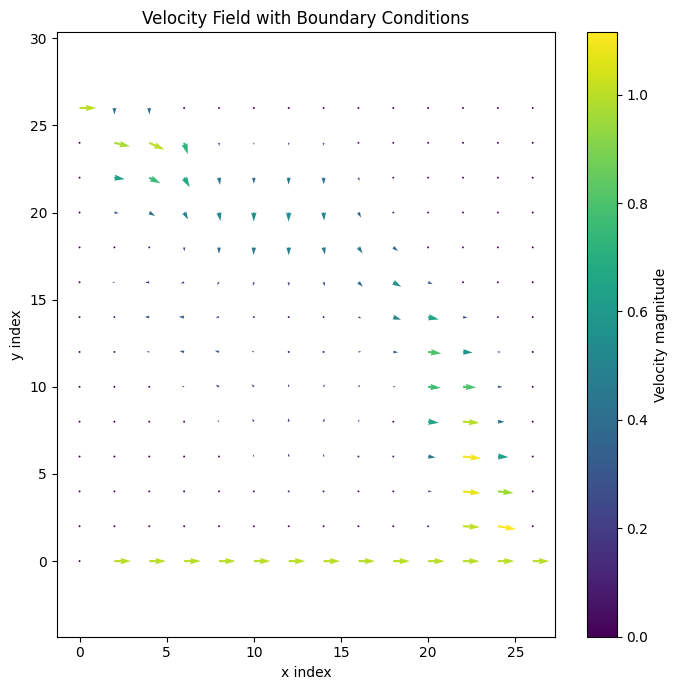

In [81]:
# Calculate height indices (6.8% from bottom)
j_hA = int(0.068 * ny)  # Inlet A height (bottom ~2 cells)
j_hC = int(0.068 * ny)  # Outlet C height
j_hD = int(0.068 * ny)  # Inlet D height (middle region)

if OVERRIDE_VELOCITY:
    print(f"\n⚠ OVERRIDING velocity field")
    print(f"Grid: {nx}x{ny}, Inlet/Outlet height: j ≤ {j_hA}")
    
    # Apply boundary conditions with height logic
    for j in range(ny):
        # RIGHT SIDE (i = nx-1 = -1)
        if j <= j_hA:
            U[-1, j] = U_A  # Inlet A (bottom right, horizontal →)
        else:
            U[-1, j] = 0.0  # Wall (top right, no flow)
        
        # LEFT SIDE (i = 0)
        if j <= j_hA:
            U[0, j] = -U_B  # Outlet B (bottom left, leftward ←)
        else:
            U[0, j] = U_C   # Outlet C (top left, rightward →)
    
    # Vertical inlet at right side middle - SPAN A REGION
    j_mid = ny // 2
    for j in range(j_mid - j_hD, j_mid + j_hD + 1):  # Span around middle
        if 0 <= j < ny:  # Bounds check
            V[-1, j] = V_D  # V_D (downward ↓)
    
    print(f"✓ Boundaries set:")
    print(f"  Right side (i={nx-1}): U_A for j≤{j_hA}, Wall for j>{j_hA}")
    print(f"  Left side (i=0): U_B for j≤{j_hA}, U_C for j>{j_hA}")
    print(f"  Middle vertical: V_D at ({nx-1}, {j_mid-j_hD} to {j_mid+j_hD})")

else:
    print("\n✓ Using velocity field from data files")

# Verify
print(f"\nVerification:")
print(f"U[-1, 0] = {U[-1, 0]:.2f} (should be {U_A})")
print(f"U[-1, {ny-1}] = {U[-1, -1]:.2f} (should be 0.0)")
print(f"U[0, 0] = {U[0, 0]:.2f} (should be {-U_B})")
print(f"U[0, {ny-1}] = {U[0, -1]:.2f} (should be {U_C})")
print(f"V[-1, {ny//2}] = {V[-1, ny//2]:.2f} (should be {V_D})")

# Plot
x = np.arange(0, nx)
y = np.arange(0, ny)
X, Y = np.meshgrid(x, y)
magnitude = np.sqrt(U**2 + V**2)

step = 2
plt.figure(figsize=(7, 7))
plt.quiver(X[::step, ::step], Y[::step, ::step],
           U[::step, ::step], V[::step, ::step],
           magnitude[::step, ::step],
           cmap='viridis', scale=30)
plt.colorbar(label='Velocity magnitude')
plt.title('Velocity Field with Boundary Conditions')
plt.xlabel('x index')
plt.ylabel('y index')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [82]:
# INITIALIZE TEMPERATURE FIELD
T = np.ones((nx, ny)) * 35.0  # Initial guess

# Set boundary values
for j in range(ny):
    if y[j] <= h_A:
        T[0, j] = T_A  # Inlet A
    if y[j] > h_C:
        T[-1, j] = T_wall  # Right wall

In [83]:
xc.shape

(26,)

In [84]:
nx

27

Iteration    0: Residual ε = 7.799099e-02
Iteration  200: Residual ε = 4.937370e-02
Iteration  400: Residual ε = 4.937369e-02
Iteration  600: Residual ε = 4.937369e-02
Iteration  800: Residual ε = 4.937369e-02
Iteration 1000: Residual ε = 4.937369e-02
Iteration 1200: Residual ε = 4.937369e-02
Iteration 1400: Residual ε = 4.937369e-02
Iteration 1600: Residual ε = 4.937369e-02
Iteration 1800: Residual ε = 4.937369e-02

⚠ Reached maximum iterations (2000)

GLOBAL ENERGY BALANCE CHECK
Inlet flux:     0.000000e+00 W
Outlet flux:    2.692308e+00 W
Wall flux:      8.587264e+00 W
Net imbalance:  -1.127957e+01 W
Error:          0.000%

✓ Energy balance satisfied!

GENERATING PLOTS

✓ Saved: solution_tdma.png


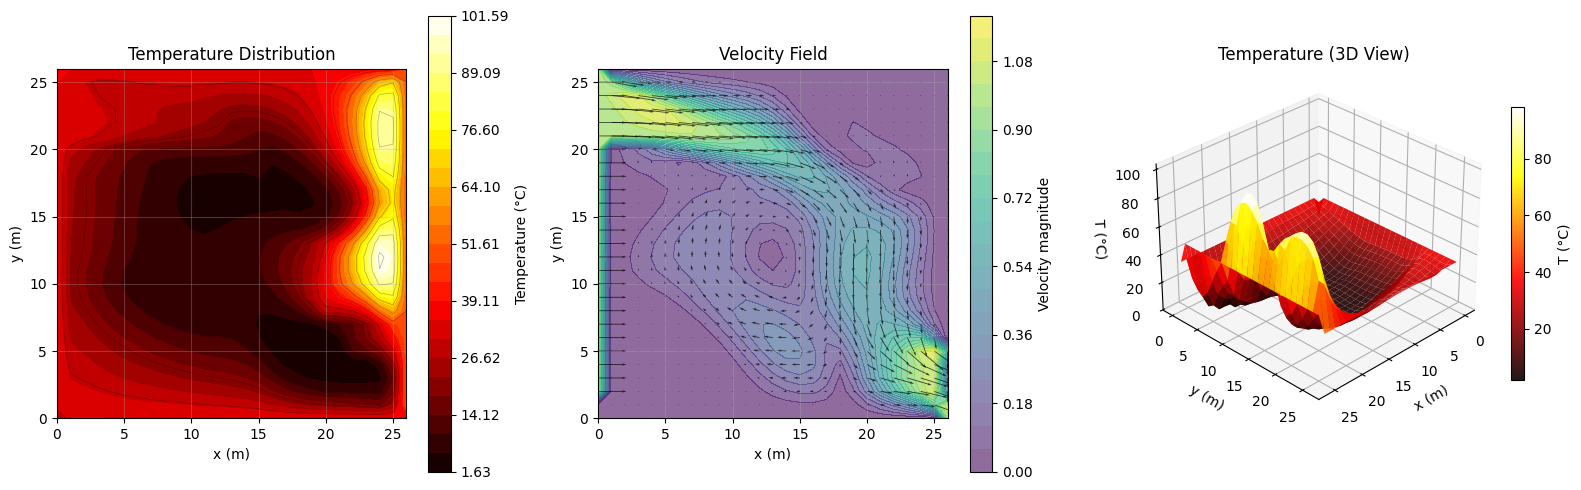


SOLUTION SUMMARY
Temperature range: [1.63, 101.59] °C
Center temperature: T(1.000, 1.000) = 6.78 °C
Energy balance error: 0.000%
Converged in 1999 iterations

Done!


In [85]:
for iteration in range(max_iter):
    T_old = T.copy()
    
    # ========================================================================
    # X-DIRECTION SWEEPS (solve along each horizontal line)
    # ========================================================================
    for j in range(1, ny-1):        
        # Build tridiagonal system for line j
        a = np.zeros(nx)  # Lower diagonal
        b = np.zeros(nx)  # Main diagonal
        c = np.zeros(nx)  # Upper diagonal
        d = np.zeros(nx)  # RHS
        
        for i in range(1, nx-1):
            dx_w = abs(xc[i-1] - xc[i])
            dy_s = abs(yc[j-1] - yc[j])
            if i != nx-2:
                dx_e = abs(xc[i+1] - xc[i])
            if j != ny-2:
                dy_n = abs(yc[j+1] - yc[j])

            # Velocities at cell faces
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusion terms
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Hybrid coefficients
            a_E = hybrid_coeff(D_e, F_e)
            a_W = hybrid_coeff(D_w, -F_w)
            a_N = hybrid_coeff(D_n, F_n)
            a_S = hybrid_coeff(D_s, -F_s)
            
            # Source term
            S = a_N * T[i, j+1] + a_S * T[i, j-1]
            
            # === BOUNDARY CONDITIONS ===
            # West boundary (left)
            if i == 1:
                if y[j] <= h_A:
                    # Inlet A: fixed temperature
                    a_W = 0
                    S += (2*D_w + max(F_w, 0)) * T_A
                else:
                    # Wall B: zero gradient
                    a_W = D_w
            
            # East boundary (right)
            if i == nx-2:
                if y[j] <= h_C:
                    # Outlet C: zero gradient
                    a_E = max(0, -F_e)
                else:
                    # Right wall: fixed temperature
                    a_E = 0
                    S += 2*D_e * T_wall
            
            # Tridiagonal coefficients
            a_P = a_E + a_W + a_N + a_S + max(0, F_e-F_w) + max(0, F_n-F_s)
            
            a[i] = -a_W
            b[i] = a_P
            c[i] = -a_E
            d[i] = S
        
        # Boundary conditions for tridiagonal system
        b[0] = 1.0
        c[0] = 0.0
        if y[j] <= h_A:
            d[0] = T_A
        else:
            d[0] = T[0, j]
        
        a[-1] = 0.0
        b[-1] = 1.0
        if y[j] > h_C:
            d[-1] = T_wall
        else:
            d[-1] = T[-1, j]
        
        # Solve tridiagonal system
        T_new = tdma_solve(a, b, c, d)
        
        # Under-relaxation
        T[:, j] = alpha * T_new + (1 - alpha) * T[:, j]
    
    # ========================================================================
    # Y-DIRECTION SWEEPS (solve along each vertical line)
    # ========================================================================
    for i in range(1, nx-1):
        # Build tridiagonal system for line i
        a = np.zeros(ny)
        b = np.zeros(ny)
        c = np.zeros(ny)
        d = np.zeros(ny)
        
        for j in range(1, ny-1):
            # Velocities at cell faces
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusion
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Hybrid coefficients
            a_E = hybrid_coeff(D_e, F_e)
            a_W = hybrid_coeff(D_w, -F_w)
            a_N = hybrid_coeff(D_n, F_n)
            a_S = hybrid_coeff(D_s, -F_s)
            
            # Source from x-direction
            S = a_E * T[i+1, j] + a_W * T[i-1, j]
            
            # Tridiagonal coefficients
            a_P = a_E + a_W + a_N + a_S + max(0, F_e-F_w) + max(0, F_n-F_s)
            
            a[j] = -a_S
            b[j] = a_P
            c[j] = -a_N
            d[j] = S
        
        # Boundary conditions
        b[0] = 1.0
        c[0] = 0.0
        d[0] = T[i, 0]
        
        a[-1] = 0.0
        b[-1] = 1.0
        d[-1] = T[i, -1]
        
        # Solve tridiagonal system
        T_new = tdma_solve(a, b, c, d)
        
        # Under-relaxation
        T[i, :] = alpha * T_new + (1 - alpha) * T[i, :]
    
    # ========================================================================
    # CONVERGENCE CHECK
    # ========================================================================
    if iteration % 50 == 0:
        # Calculate residual for all interior cells
        residual_sum = 0.0
        cell_count = 0
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                # Velocities at cell faces
                u_e = 0.5 * (U[i,j] + U[i+1,j])
                u_w = 0.5 * (U[i,j] + U[i-1,j])
                v_n = 0.5 * (V[i,j] + V[i,j+1])
                v_s = 0.5 * (V[i,j] + V[i,j-1])
                
                # Fluxes
                F_e = rho * u_e * dy
                F_w = rho * u_w * dy
                F_n = rho * v_n * dx
                F_s = rho * v_s * dx
                
                # Diffusion
                D_e = Gamma * dy / dx
                D_w = Gamma * dy / dx
                D_n = Gamma * dx / dy
                D_s = Gamma * dx / dy
                
                # Hybrid coefficients
                a_E = hybrid_coeff(D_e, F_e)
                a_W = hybrid_coeff(D_w, -F_w)
                a_N = hybrid_coeff(D_n, F_n)
                a_S = hybrid_coeff(D_s, -F_s)
                a_P = a_E + a_W + a_N + a_S + max(0, F_e-F_w) + max(0, F_n-F_s)
                
                # Source term (zero for this problem, unless you have heat sources)
                S = 0.0
                
                # Calculate residual for this cell
                residual = abs(a_E * T[i+1, j] + a_W * T[i-1, j] + 
                             a_N * T[i, j+1] + a_S * T[i, j-1] + 
                             S - a_P * T[i, j])
                
                residual_sum += residual
                cell_count += 1
        
        # Calculate average residual (epsilon)
        epsilon = residual_sum / cell_count if cell_count > 0 else 0.0
        
        if iteration % 200 == 0:
            print(f"Iteration {iteration:4d}: Residual ε = {epsilon:.6e}")
        
        # Check convergence
        if epsilon < tolerance:
            print(f"\n✓ Converged at iteration {iteration}")
            print(f"  Residual ε = {epsilon:.6e}")
            break


if iteration == max_iter - 1:
    print(f"\n⚠ Reached maximum iterations ({max_iter})")

# ============================================================================
# GLOBAL ENERGY BALANCE
# ============================================================================
print("\n" + "="*70)
print("GLOBAL ENERGY BALANCE CHECK")
print("="*70)

# Inlet flux
flux_in = 0
for j in range(ny):
    if y[j] <= h_A:
        flux_in += rho * U[0,j] * T_A * dy

# Outlet flux
flux_out = 0
for j in range(ny):
    if y[j] <= h_C:
        flux_out += rho * U[-1,j] * T[-1,j] * dy

# Wall flux (diffusive)
flux_wall = 0
for j in range(ny):
    if y[j] > h_C:
        dT_dx = (T[-1,j] - T[-2,j]) / dx
        flux_wall += -Gamma * dT_dx * dy

# Balance
net_flux = flux_in - flux_out - flux_wall
error_pct = abs(net_flux / flux_in) * 100 if flux_in > 0 else 0

print(f"Inlet flux:     {flux_in:12.6e} W")
print(f"Outlet flux:    {flux_out:12.6e} W")
print(f"Wall flux:      {flux_wall:12.6e} W")
print(f"Net imbalance:  {net_flux:12.6e} W")
print(f"Error:          {error_pct:.3f}%")

if error_pct < 1.0:
    print("\n✓ Energy balance satisfied!")
else:
    print(f"\n⚠ Energy imbalance: {error_pct:.2f}%")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("GENERATING PLOTS")
print("="*70)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(16, 5))

# Temperature contour
ax1 = fig.add_subplot(131)
levels = np.linspace(T.min(), T.max(), 25)
cf = ax1.contourf(X, Y, T.T, levels=levels, cmap='hot')
plt.colorbar(cf, ax=ax1, label='Temperature (°C)')
ax1.contour(X, Y, T.T, levels=10, colors='black', alpha=0.3, linewidths=0.5)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Temperature Distribution')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Velocity field
ax2 = fig.add_subplot(132)
skip = max(1, nx//25)
vel_mag = np.sqrt(U**2 + V**2)
cf2 = ax2.contourf(X, Y, vel_mag.T, levels=20, cmap='viridis', alpha=0.6)
plt.colorbar(cf2, ax=ax2, label='Velocity magnitude')
ax2.quiver(X[::skip,::skip], Y[::skip,::skip], 
           U.T[::skip,::skip], V.T[::skip,::skip], alpha=0.7)
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_title('Velocity Field')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# 3D surface
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X, Y, T.T, cmap='hot', edgecolor='none', alpha=0.9)
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_zlabel('T (°C)')
ax3.set_title('Temperature (3D View)')
ax3.view_init(elev=30, azim=45)
plt.colorbar(surf, ax=ax3, shrink=0.6, label='T (°C)')

plt.tight_layout()
plt.savefig('solution_tdma.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: solution_tdma.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SOLUTION SUMMARY")
print("="*70)
print(f"Temperature range: [{T.min():.2f}, {T.max():.2f}] °C")
print(f"Center temperature: T({L/2:.3f}, {H/2:.3f}) = {T[nx//2, ny//2]:.2f} °C")
print(f"Energy balance error: {error_pct:.3f}%")
print(f"Converged in {iteration} iterations")
print("="*70)
print("\nDone!")
